In [65]:
%matplotlib notebook
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

def get_ordered_colors(cmap, n, lb=0, ub=1):
    cmap = cm.get_cmap(cmap)
    return cmap(np.linspace(lb, ub, n))

Our aim here is to investigate the circumstances under which recurrent inhibition can narrow and perhaps stabilize the range of possible propagation speeds of a feedforward excitatory network.

Let's begin by considering a single LIF neuron embedded in an excitatory layer of cells within the feedforward network.

### LIF neuron governing equation

A current-based LIF neuron has the following governing equation:

$$ \tau \dot{V}(t) = -V(t) + \frac{\tau}{C} I(t) $$

The solution has the general form:

$$ V(t) = V_0 + \frac{1}{C} \int_{0}^{t} I(t') e^{-(t-t')/ \tau } dt' $$

When driven with constant current $I_0$, the voltage is:

$$ V(t) = V_0 + \frac{I_0}{C} \int_{0}^{t} e^{-(t-t')/ \tau } dt' \\
        = V_0 + \frac{I_0 \tau}{C} (1 - e^{-t/\tau}) $$
        

### Dynamics of an excitatory cell receiving feedforward excitation and global inhibition

Suppose a neuron has been driven for a long time with current $I_{i}$, representing the global inhibition supplied by the inhibitory pool given steady-state propagating dynamics of the chain:

$$ V(t) = V = V_0 + \frac{I_i \tau}{C} $$

At time $t_0$, the excitation propagating along the chain begins to excite the neuron in question. Introduce a new component to the input current, $I_e$ such that $I(t > t_0) = I_i + I_e$:

$$ V(t > t_0) = V_0 + \frac{I_i \tau}{C} + \frac{(I_i + I_e) \tau}{C} (1 - e^{-t/\tau}) $$

To calculate time-to-threshold, solve:

$$ V_{th} = V_0 + \frac{I_i \tau}{C} + \frac{I_e \tau}{C} (1 - e^{-t^*/\tau}) $$

$$ (1 - e^{-t^*/\tau}) = \left(V_{th} - V_0 - \frac{I_i \tau}{C}\right) \frac{C}{\tau I_e} $$

$$ t^* = - \tau \log\left(1 - \frac{C}{\tau I_e} \left(V_{th} - V_0 - \frac{I_i \tau}{C}\right)\right) $$

### Model of the inhibitory pool

We have not yet specified the coupling from the excitatory cells to the inhibitory pool and back yet, but let us assume that E cells are coupled to I cells with sufficient strength so that individual spikes from E cells always evoke spikes from their coupled I cells. In this limit, the frequency of spikes in an I cell is linear with the frequency of spikes of an E cell that drives it, i.e. a firing rate approximation is suitable.

If we further assume that coupling from I cells to E cells in the chain is global and uniform, then $I_i(t)$ is a linear function of $I_e(t)$ with some time lag.

For ease of calculation, let us assume $I_i(t) = A I_e(t)$, where $A < 0$. We then have:

$$ t^* = -\tau \log\left[1 - \frac{C}{\tau I_e(t)} \left(V_{th} - V_0 - \frac{\tau A I_e(t)}{C}\right)\right] \\ 
        = -\tau \log\left[1 - \left(\frac{C \left(V_{th} - V_0 \right) }{\tau I_e(t)} - A\right)\right] $$


Let us define $\alpha = C \left(V_{th} - V_0 \right) / \tau$ and simplify a bit:

$$ t^*  = -\tau \log\left[1 + A - \frac{\alpha}{I_e(t)}\right] $$

Here, $A < 0$, $\alpha > 0$, and $I_e(t) \geq 0$ by definition.

<IPython.core.display.Javascript object>


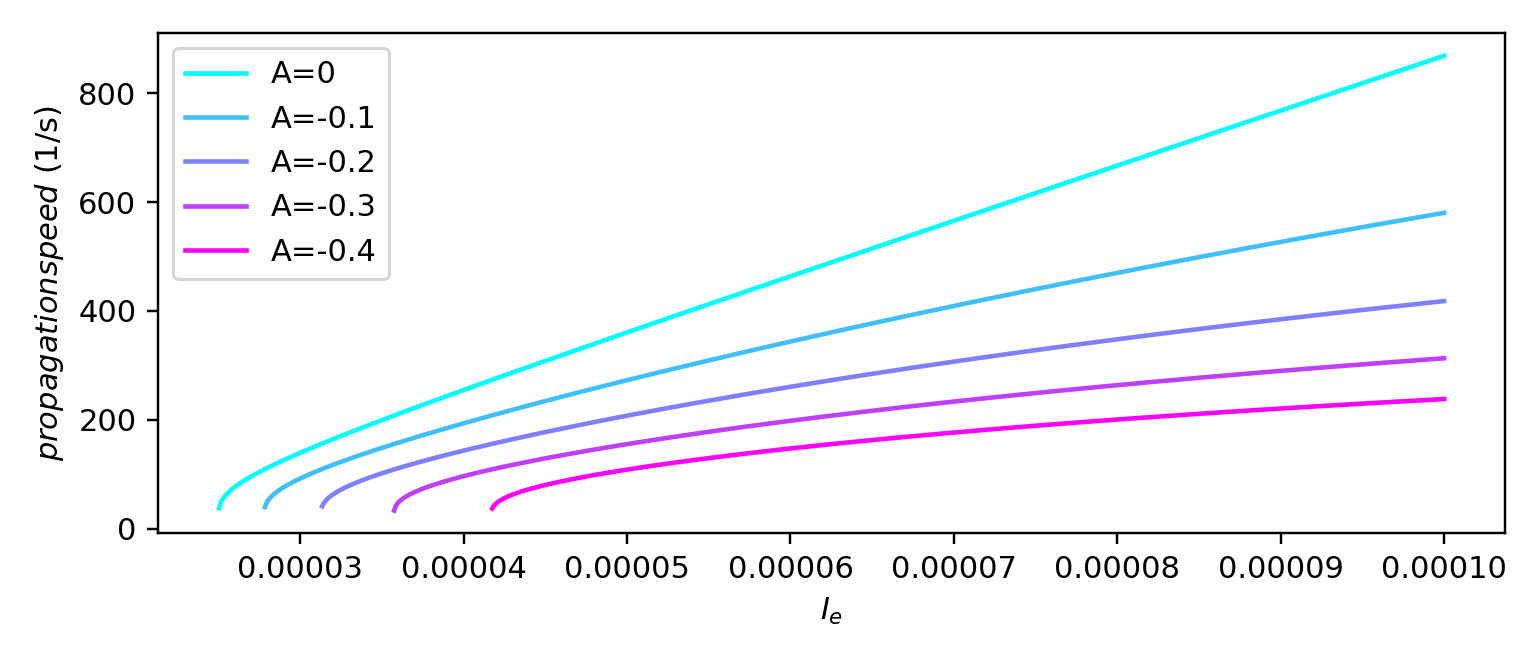

Text(0.5, 0, '$I_e$')

In [79]:
tau = 4e-3
c = 1e-6
v_th = -0.5
v_0 = -0.6

alpha = c / tau * (v_th - v_0)

def t_star(a, i_e):
    return -tau * np.log(1 + a - alpha / i_e)

fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)

i_e = np.linspace(1e-8, 0.1e-3, 1000)

colors = get_ordered_colors('cool', 5)

for i, a in enumerate([0, -0.1, -.2, -.3, -.4]):
    ax.plot(i_e, 1/t_star(a, i_e), c=colors[i], label=f'A={a}')
ax.legend()
ax.set_ylabel(r'$propagation speed$ (1/s)')
ax.set_xlabel(r'$I_e$')

### Output current

Consider the output current of all neurons in an excitatory layer. This is roughly:
    
$$ I_{out}(t) \approx \frac{C J_0}{t^*} $$

where $J_0$ is the total coupling from the driven neurons to the next layer. Therefore:

$$ I_{out}(t) \approx -\frac{C J_0}{\tau} \left[\log\left(1 + \frac{A}{1+A} - \frac{\alpha}{(1+A) I_e(t)}\right)\right]^{-1} $$

<IPython.core.display.Javascript object>


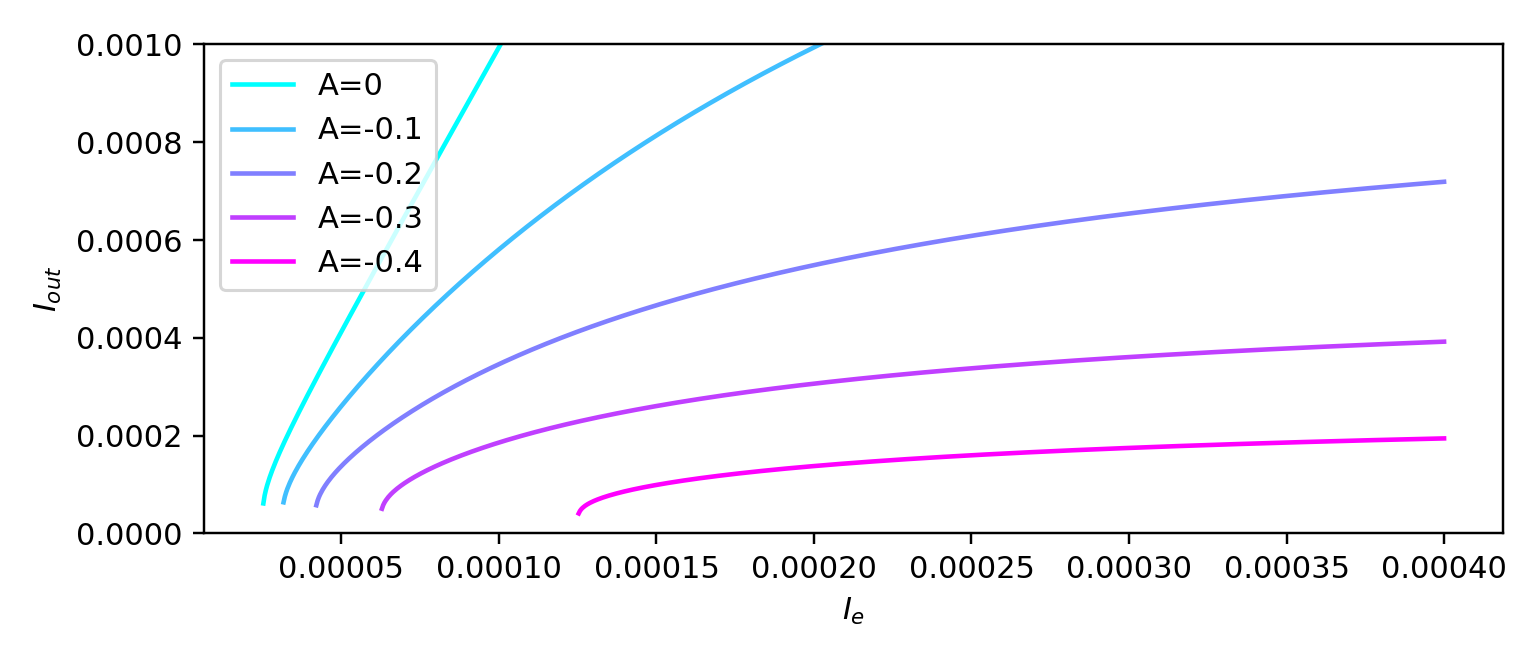

(0.0, 0.001)

In [67]:
j_0 = 0.26 * 0.004 * 1.1 * 0.5 * 2000
beta = c * j_0

def i_out(a, i_e):
    return beta / t_star(a, i_e)

fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)

i_e = np.linspace(1e-8, 4e-4, 1000)
colors = get_ordered_colors('cool', 5)

for i, a in enumerate([0, -0.1, -.2, -.3, -.4]):
    ax.plot(i_e, i_out(a, i_e), c=colors[i], label=f'A={a}')
ax.legend()
ax.set_ylabel(r'$I_{out}$')
ax.set_xlabel(r'$I_e$')
ax.set_ylim(0, 1e-3)

There are clearly fixed points to these dynamics, but are they stable?

Consider:
    
$$ I_{out}(t) \approx -\frac{C J_0}{\tau} \left[\log\left(1 + \frac{A}{1+A} - \frac{\alpha}{(1+A) I_e(t)}\right)\right]^{-1} $$

Define $\beta = 1 + \frac{A}{1+A} - \frac{\alpha}{(1+A) I_e(t)}$ and take the derivative with respect to $I_e(t)$ of both sides:

$$ \frac{dI_{out}(t)}{dI_e(t)} \approx -\frac{C J_0}{\tau} \frac{1}{\beta \left(\log(\beta)\right)^2} \frac{d\beta}{I_e(t)} $$

$$ = -\frac{C J_0}{\tau} \frac{1}{\beta \left(\log(\beta)\right)^2} \frac{\alpha}{(1+A)I_e^2(t)} $$


For values of $A$ s.t. $-0.5 < A < 0$, $\beta$ is always less than 1. When $\beta \leq 0$, the log is undefined, so this derivative will always be positive as we could have intuited from the above graphs. 

Any fixed points of the dynamics are unstable, but do they change rapidly? To answer this, consider:

$$ \frac{\frac{dI_{out}(t)}{dI_e(t)}}{I_{out}(t)} = -\frac{1}{\beta \log \beta} \frac{\alpha}{(1+A)I_e^2(t)}$$

As $I_e(t)$ grows, $\beta \rightarrow \frac{1 + 2A}{1 + A}$. Given that $\beta$ does not approach 0 or 1, which happens when $A = 0$ or $A = -0.5$, then this ratio becomes very small, indicating that while the dynamics are unstable, they change very slowly.

### Structured inhibition

For a structured inhibiton network, we can repeat our calculations above, but now assume that at time $t > t_0$, the current is simply $I_e(t)$ because the structure of the inhibition will shield the neurons being excited from inhibition at time $t_0$ and a short while after. We then have:

$$ t^*  = -\tau \log\left[1 + A - \frac{\alpha}{ I_e(t)}\right] $$



We see in the limit that $I_e(t) >> \alpha$, $A$ can take values from -1 to 0. Notice that this limit is different from the limit $(1+A) I_e(t) >> \alpha$ discussed in the unstructed case, which required $I_e(t)$ to be larger for $t^*$'s dependence on it to drop out.

<IPython.core.display.Javascript object>


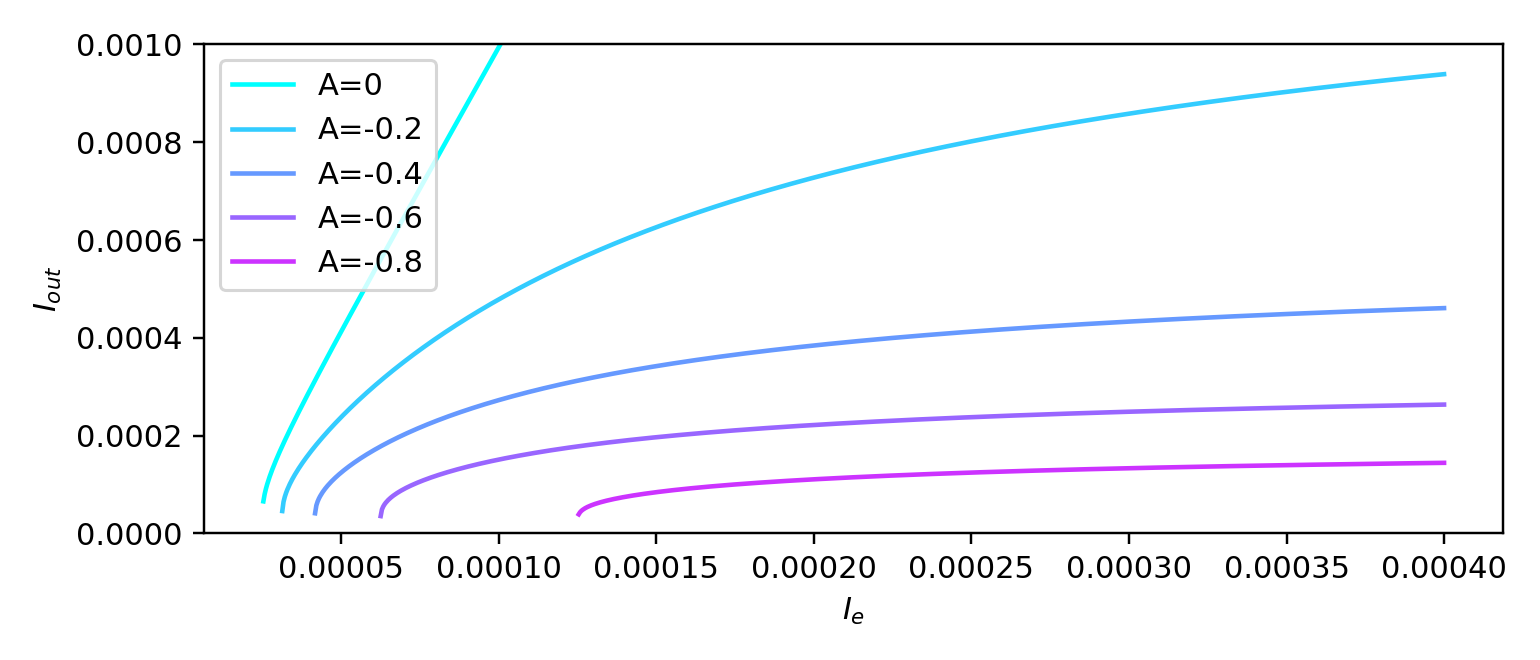

(0.0, 0.001)

In [68]:
def t_star_structed(a, i_e):
    return -tau * np.log(1 + a - alpha / i_e)

def i_out_structed(a, i_e):
    return beta / t_star_structed(a, i_e)

fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)

i_e = np.linspace(1e-7, 4e-4, 1000)
colors = get_ordered_colors('cool', 6)

for i, a in enumerate([0, -0.2, -.4, -.6, -.8]):
    ax.plot(i_e, i_out_structed(a, i_e), c=colors[i], label=f'A={a}')
ax.legend()
ax.set_ylabel(r'$I_{out}$')
ax.set_xlabel(r'$I_e$')
ax.set_ylim(0, 1e-3)

### Comparison of structured and unstructured networks with recurrence tuned so that neurons will activate at the same minimum current

<IPython.core.display.Javascript object>


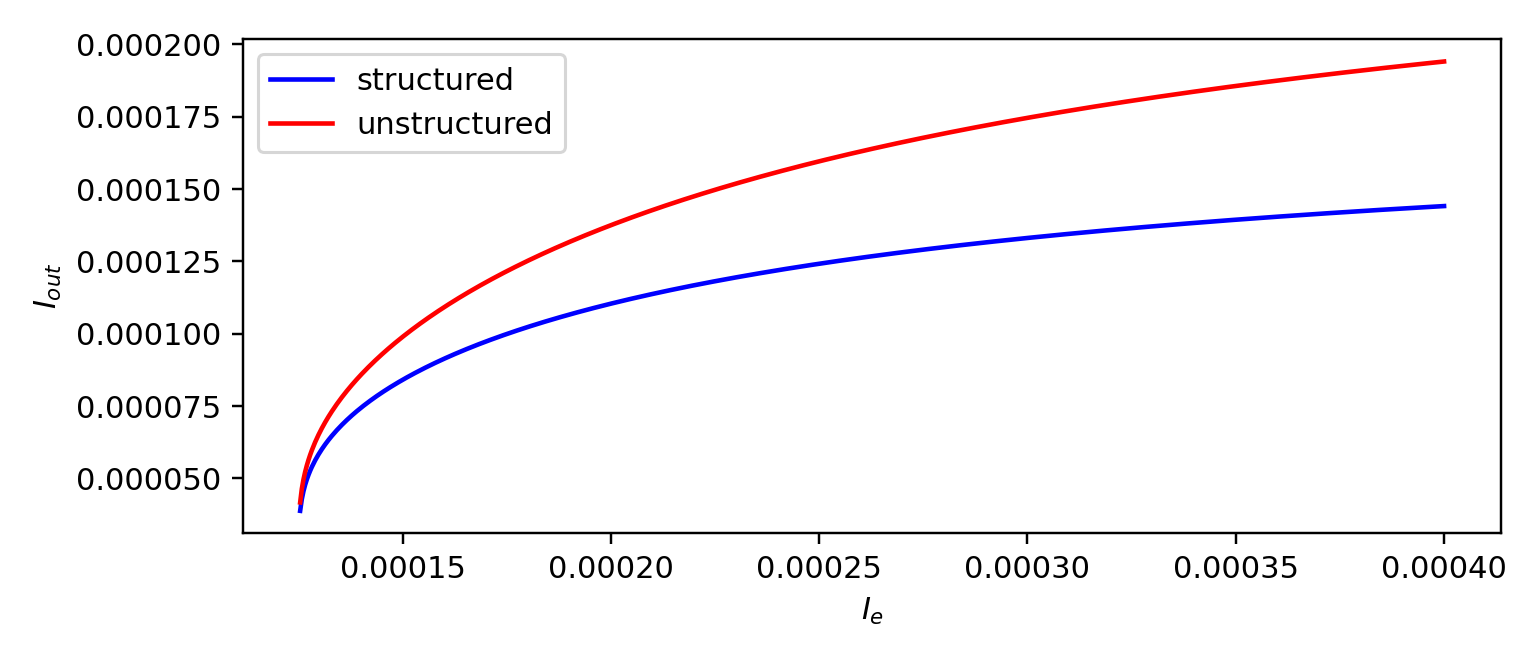

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)

i_e = np.linspace(1e-7, 4e-4, 1000)
colors = get_ordered_colors('cool', 6)

ax.plot(i_e, i_out_structed(-0.8, i_e), c='blue', label='structured')
ax.plot(i_e, i_out(-0.4, i_e), c='red', label='unstructured')

ax.set_ylabel(r'$I_{out}$')
ax.set_xlabel(r'$I_e$')
ax.legend()